In [22]:
import pandas as pd
import numpy as np
from ydata_profiling import ProfileReport
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
%matplotlib inline


## Kỹ năng chuyên môn

### Phân tích dữ liệu nâng cao

In [23]:
df = pd.read_csv('retail_sales_dataset.csv')

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Transaction ID    1000 non-null   int64 
 1   Date              1000 non-null   object
 2   Customer ID       1000 non-null   object
 3   Gender            1000 non-null   object
 4   Age               1000 non-null   int64 
 5   Product Category  1000 non-null   object
 6   Quantity          1000 non-null   int64 
 7   Price per Unit    1000 non-null   int64 
 8   Total Amount      1000 non-null   int64 
dtypes: int64(5), object(4)
memory usage: 70.4+ KB


In [25]:
# Dùng ProfileReport để tạo báo cáo thống kê nhanh
profile = ProfileReport(df, title="Profiling Report")
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Price per Unit là giá bán ra không phải giá Vốn nên `Quantity * Price per Unit` tương đương với Total Amount. 
Do đó tôi đề xuất tạo cột `Cost per Unit` tương ứng với giá vốn hàng bán. Để xây dựng `Cost per Unit`, tôi sẽ làm như sau:
- Với mỗi transaction, tạo ngẫu nhiên tỉ lệ từ nhóm `[95%, 90% , 85%, 80%]`
- Nhân Price với tỉ lệ để ra `Cost per Unit`
- Công thức được tính lại `Profit = Total Amount - Quantity * Cost per Unit`

In [26]:
np.random.seed(42)
df['rd'] = np.random.choice([0.95, 0.9, 0.85, 0.80], replace=True, size=df.shape[0])
df['Cost per Unit'] = df['Price per Unit'] * df['rd']
df['Profit'] = df['Total Amount'] - df['Quantity']*df['Cost per Unit']
df.head()

,Transaction ID,Date,Customer ID,Gender,Age,Product Category,Quantity,Price per Unit,Total Amount,rd,Cost per Unit,Profit
0,1,2023-11-24,CUST001,Male,34,Beauty,3,50,150,0.85,42.5,22.5
1,2,2023-02-27,CUST002,Female,26,Clothing,2,500,1000,0.80,400.0,200.0
2,3,2023-01-13,CUST003,Male,50,Electronics,1,30,30,0.95,28.5,1.5
3,4,2023-05-21,CUST004,Male,37,Clothing,1,500,500,0.85,425.0,75.0
4,5,2023-05-06,CUST005,Male,30,Beauty,2,50,100,0.85,42.5,15.0


In [27]:
profit = df.groupby('Product Category')['Profit'].sum()
profit

Product Category
Beauty         18124.75
Clothing       20497.25
Electronics    19158.50
Name: Profit, dtype: float64

Dữ liệu chỉ có 3 nhóm sản phẩm thôi, không có tên/mã từng sản phẩm nên tôi đề xuât sửa đề 
> Tính toán và hiển thị **5 sản phẩm** có lợi nhuận cao nhất và **5 sản phẩm** có lợi nhuận thấp nhất

thành 

> Tính toán và hiển thị **5 Giao dịch (Transaction)** có lợi nhuận cao nhất và **5 Giao dịch (Transaction)** có lợi nhuận thấp nhất


In [28]:
# Top 5 transactions có profit cao nhất
df.nlargest(n=5, columns='Profit')

,Transaction ID,Date,Customer ID,Gender,Age,Product Category,Quantity,Price per Unit,Total Amount,rd,Cost per Unit,Profit
14,15,2023-01-16,CUST015,Female,42,Electronics,4,500,2000,0.8,400.0,400.0
88,89,2023-10-01,CUST089,Female,55,Electronics,4,500,2000,0.8,400.0,400.0
252,253,2023-08-31,CUST253,Female,53,Clothing,4,500,2000,0.8,400.0,400.0
280,281,2023-05-23,CUST281,Female,29,Beauty,4,500,2000,0.8,400.0,400.0
341,342,2023-10-24,CUST342,Female,43,Clothing,4,500,2000,0.8,400.0,400.0


In [29]:
# Top 5 transactions có profit thấp nhất
df.nsmallest(n=5, columns='Profit')

,Transaction ID,Date,Customer ID,Gender,Age,Product Category,Quantity,Price per Unit,Total Amount,rd,Cost per Unit,Profit
184,185,2023-02-27,CUST185,Male,24,Clothing,1,25,25,0.95,23.75,1.25
203,204,2023-09-28,CUST204,Male,39,Beauty,1,25,25,0.95,23.75,1.25
205,206,2023-08-05,CUST206,Male,61,Clothing,1,25,25,0.95,23.75,1.25
229,230,2023-04-23,CUST230,Male,54,Beauty,1,25,25,0.95,23.75,1.25
317,318,2023-10-24,CUST318,Male,61,Clothing,1,25,25,0.95,23.75,1.25


### Phân tích hành vi khách hàng

In [30]:
df['Age_Group'] = pd.cut(df['Age'], bins = [0, 24,40,np.inf], labels=['<25', '25-40', '>40'])

In [31]:
# Tổng doanh thu và lợi nhuận cho từng nhóm khách hàng
chi_phi_loi_nhuan_df = df.groupby(['Age_Group','Gender'])[['Total Amount','Profit']].agg(['sum']).reset_index()
chi_phi_loi_nhuan_df.columns = [c[0] for c in chi_phi_loi_nhuan_df.columns]
chi_phi_loi_nhuan_df

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_23000\1476087374.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  chi_phi_loi_nhuan_df = df.groupby(['Age_Group','Gender'])[['Total Amount','Profit']].agg(['sum']).reset_index()


,Age_Group,Gender,Total Amount,Profit
0,<25,Female,35920,5624.00
1,<25,Male,38730,3818.50
2,25-40,Female,84480,12769.00
3,25-40,Male,69765,7236.25
4,>40,Female,112440,17442.00
5,>40,Male,114665,10890.75


In [32]:
chi_phi_loi_nhuan_df['ROI'] = chi_phi_loi_nhuan_df['Profit'] / chi_phi_loi_nhuan_df['Total Amount']
chi_phi_loi_nhuan_df.sort_values(['Gender', 'Age_Group'])

,Age_Group,Gender,Total Amount,Profit,ROI
0,<25,Female,35920,5624.00,0.156570
2,25-40,Female,84480,12769.00,0.151148
4,>40,Female,112440,17442.00,0.155123
1,<25,Male,38730,3818.50,0.098593
3,25-40,Male,69765,7236.25,0.103723
5,>40,Male,114665,10890.75,0.094979


- Nhóm khách hàng mang tổng lợi nhuẩn cao nhất là nhóm `Female và tuổi >40`, tuy nhiên nhóm mang lại `ROI` cao nhất lại là nhóm `Female <25 tuổi`
- Ở tất cả các nhóm tuổi thì `Female` đều có tỉ lệ ROI cao hơn `Male`

In [33]:
# tạo bảng tính tổng lượng sản phẩm bán ra và trung bình số lượng sản phẩm mua trong 1 giao dịch
female_df_quantity = df[df['Gender']== 'Female'].groupby(['Age_Group','Product Category'])['Quantity'].agg(['sum','mean']).reset_index()
female_df_quantity

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_23000\2405085321.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  female_df_quantity = df[df['Gender']== 'Female'].groupby(['Age_Group','Product Category'])['Quantity'].agg(['sum','mean']).reset_index()


,Age_Group,Product Category,sum,mean
0,<25,Beauty,70,2.413793
1,<25,Clothing,38,2.375000
2,<25,Electronics,67,2.481481
3,25-40,Beauty,141,2.660377
4,25-40,Clothing,133,2.509434
5,25-40,Electronics,160,2.758621
6,>40,Beauty,207,2.464286
7,>40,Clothing,270,2.571429
8,>40,Electronics,212,2.494118


<Axes: xlabel='Age_Group', ylabel='mean'>

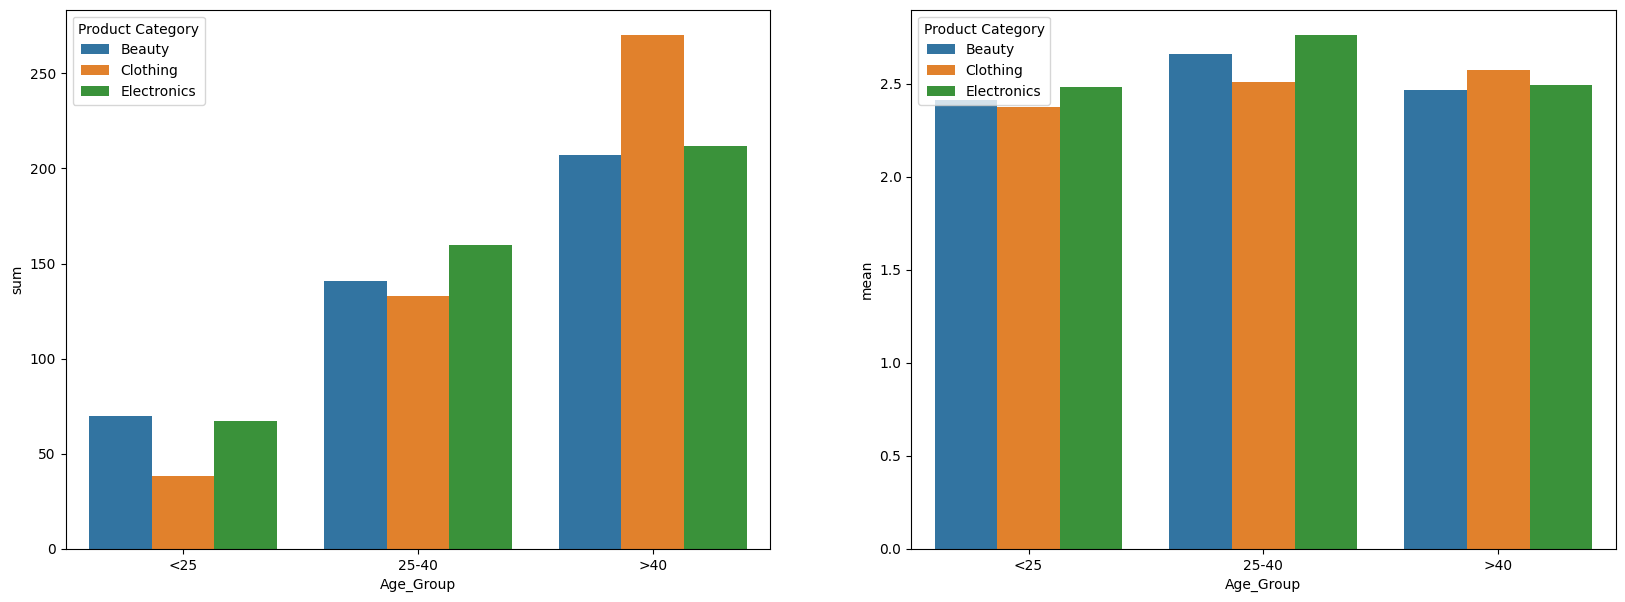

In [34]:
fig, axes =plt.subplots(1,2, figsize=(20,7))
sns.barplot(hue='Product Category', y='sum', x='Age_Group', data=female_df_quantity, ax=axes[0])
sns.barplot(hue='Product Category', y='mean', x='Age_Group', data=female_df_quantity, ax=axes[1])

Đối với nữ giới thì 
- Nhóm tuổi > 40 thì quan tâm đến `Clothing` nhiều hơn 
- Hai nhóm còn lại quan tâm đến `Beauty` và `Electronics` nhiều hơn. Do đó cần tập trung tiếp thị Clothing cho nhóm lớn tuổi nhất và `Beauty & Electronics` cho 2 nhóm tuổi còn lại
- Nhóm tuổi 25-40 có sức mua trung bình trên 1 giao dịch cao hơn so với 2 nhóm còn lại, nên tập trung các phương pháp `Cross sale` cho nhóm này

In [35]:
# tạo bảng tính tổng lượng sản phẩm bán ra và trung bình số lượng sản phẩm mua trong 1 giao dịch
female_df_price = df[df['Gender']== 'Female'].groupby(['Age_Group','Price per Unit']).size().reset_index()
female_df_price.columns = ['Age_Group', 'Price per Unit', 'value']

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_23000\468403835.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  female_df_price = df[df['Gender']== 'Female'].groupby(['Age_Group','Price per Unit']).size().reset_index()


<Axes: xlabel='Age_Group', ylabel='value'>

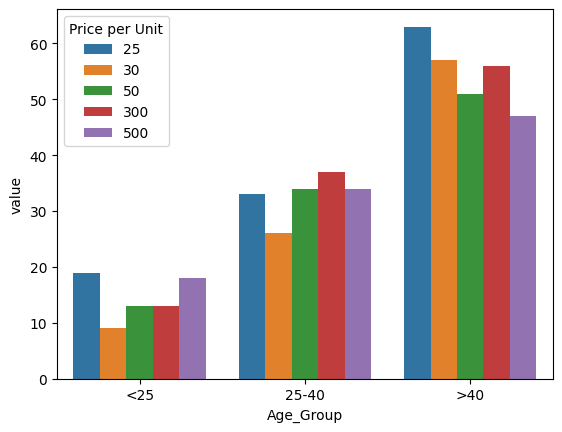

In [36]:
sns.barplot(hue='Price per Unit', y='value', x='Age_Group', data=female_df_price, palette='tab10')

- Nhóm tuổi > 40 có xu hướng mua những đồ có giá trị thấp hơn 
- Nhóm < 25 tuổi hoặc là mua rẻ nhất hoặc là mua đồ đắt nhất
- Nhóm từ 25-40 hầu hết không có khác biệt về giá.

Do đó chúng ta có thể tập trung phương pháp `Up sale` cho nhóm `<25` cao và có thể áp dụng thêm cho nhóm `25-40`

## Modeling

In [37]:
train, test = train_test_split(df, test_size=0.2, random_state=42)
train, valid = train_test_split(train, test_size=0.25, random_state=42)
print(train.shape, valid.shape, test.shape)

(600, 13) (200, 13) (200, 13)


In [38]:
model = LinearRegression()
target = 'Total Amount'

In [39]:
scaler = RobustScaler()
features = ['Quantity', 'Price per Unit', 'Age']
X_train_scaled = scaler.fit_transform(train[features])
X_valid_scaled = scaler.transform(valid[features])
X_test_scaled = scaler.transform(test[features])

In [40]:
model.fit(X_train_scaled, train[target])
y_pred_valid = model.predict(X_valid_scaled)
y_pred_test = model.predict(X_test_scaled)

Sử dụng thêm metric adjusted_r_squared dựa trên số samples và số features

In [41]:
def adjusted_r_squared_error(y_true, y_pred, n_features):
    n_samples = len(y_true)
    r2 = r2_score(y_true, y_pred)
    adj_r2 = 1 - (1- r2) * (n_samples - 1) / (n_samples- n_features-1)
    return adj_r2
print("MAE valid", mean_absolute_error(valid[target],y_pred_valid))
print("MAE test", mean_absolute_error(test[target],y_pred_test))
print('-'*10)
print("R2 valid", r2_score(valid[target],y_pred_valid))
print("R2 test", r2_score(test[target],y_pred_test))
print('-'*10)
print('Adjusted R2 valid', adjusted_r_squared_error(valid[target],y_pred_valid, n_features=len(features)))
print('Adjusted R2 test', adjusted_r_squared_error(test[target],y_pred_test, n_features=len(features)))

MAE valid 182.16343269655692
MAE test 174.72005222084624
----------
R2 valid 0.850419113307043
R2 test 0.8555626111705221
----------
Adjusted R2 valid 0.8481296099392936
Adjusted R2 valid 0.8533518348108873


Text(0.5, 1.0, ' Biểu đồ so sánh dự đoán và thực tế')

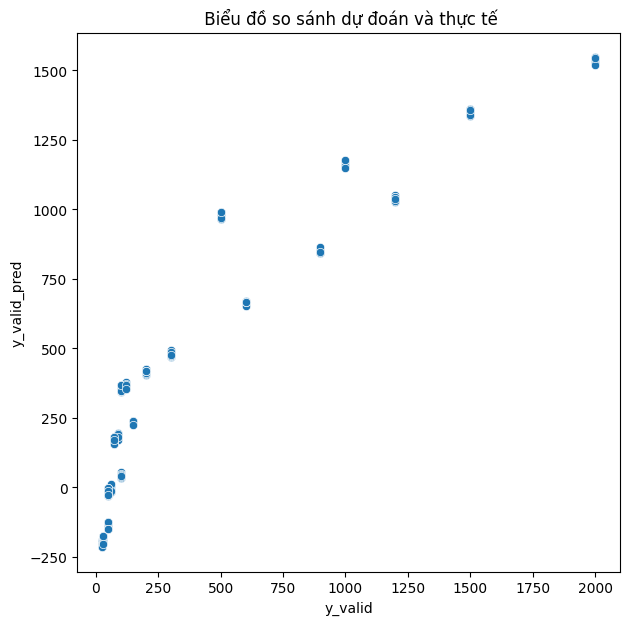

In [42]:
plt.figure(figsize=(7,7))
sns.scatterplot(x=valid[target], y=y_pred_valid)
plt.xlabel('y_valid')
plt.ylabel('y_valid_pred')
plt.title(" Biểu đồ so sánh dự đoán và thực tế")

## Xây dựng outline

### Mục tiêu tổng quan của khóa học
- Khóa học Python for Data Analysis nhằm trang bị cho học viên kiến thức và kỹ năng cần thiết để sử dụng Python như một công cụ mạnh mẽ trong việc phân tích dữ liệu. 
- Học viên sẽ học cách thu thập, làm sạch, trực quan hóa và phân tích dữ liệu để đưa ra những quyết định dựa trên dữ liệu chính xác và có cơ sở. 
- Ngoài ra học viên còn có thể áp dụng một số mô hình máy học cơ bản trong quá trình phân tích dự đoán.

### Sau khi hoàn thành khóa học, học viên sẽ đạt được:
- Biết Sử dụng các IDE hoặc Code Editor như Jupyter NoteBook, Google Colab, Visual Studio Code
- Sử dụng được Python ở mức cơ bản
- Làm quen với các thư viện xử lý dữ liệu và trực quan hóa dữ liệu của Python như như Pandas,Matplotlib, Seaborn,
- Ôn lại các kiến thức thống kê và sử dụng các thư viện thống kê để thực hiện các kiểm định và ước lượng
- Học được một số cách tính xác suất cơ bản
- Phân biệt được các phương pháp học máy như học Có giám sát, học Không giám sát.
- Phân biệt được các loại học máy có giám sát như Regression và Classification
- Sử dụng thư viện Sklearn để xây dựng các mô hình học máy
- Nắm bắt được một số kỹ thuật Feature Engineering cơ bản

### Buổi 1 (Warm up): Giới thiệu Python và các công cụ
- Giới thiệu khóa học
- Giới thiệu về Python
- Giới thiệu về Anaconda
- Giới thiệu Jupyter Notebook và cách sử dụng
- Giới thiệu Google Colab và cách sử dụng
- GIới thiệu Visual Studio Code và cách sử dụng

### Buổi 2: Nhập môn Python
-  Giới thiệu các biến trong Python
-  Các kiểu dữ liệu cơ bản: float, int, str, bool
-  Chuyển đổi dữ liệu
-  Cấu trúc dữ liệu cơ bản: List, set, tuple, dictionary
-  Toán tử số học, toán tử so sánh, toán tử logic
-  Các phương thức trên string
-  Các phương thức cho dữ liệu Datetime
-  Cách chạy python script
-  Comment trong python
-  Câu lệnh có điều kiện
-  Vòng lặp trong python
-  Function

### Buổi 3: Python nâng cao
-  Đọc và ghi dữ liệu vào tệp bằng Python
-  Lambda Function, map, reduce, filter
-  Các cấu trúc dữ liệu trong collections: namedtuple, Counter, defautdict
-  Iterators trong Python
-  List, dict comprehension
-  Numpy cơ bản
-  Kết nối với Database(Oracle)
-  Error Handling

### Buổi 4: Xử lý dữ liệu với Pandas (Phần 1)
- Giới thiệu về Pandas
- Giới thiệu về Series, DataFrame
- Các kiểu dữ liệu trong Pandas
- Nhập xuất dữ liệu với Pandas
- Một số hàm cơ bản
- Chọn và lọc dữ liệu
- Tính toán trên các phần tử trong Pandas

### Buổi 5: Xử lý dữ liệu với Pandas (Phần 2)
- Các cách phối hợp nhiều bảng với nhau: Join, Merge, Concat
- So sánh các cách phối hợp các bảng
- Groupby trong pandas
- Làm việc với 1 số kiểu dữ liệu: text, timestamp, category
- Xử lý missing data
- Multiindex
- Pivot và Melt
- Resample
- Window và Rolling

### Buổi 6: Trực quan hóa dữ liệu với matplotlib
- Giới thiệu một số package: matplotlib, seaborn, altair, plotlty
- Axes trong matplotlib
- Tùy chỉnh Plot cơ bản: title, axis title, label, limit, ... trong matplotlib
- Xuất chart dưới dạng ảnh
- Line chart, Barchart, Historgram, Scatter plot, boxplot
- Countplot và KDE plot với seaborn
- Tạo subplot
- Tùy chỉnh plot nâng cao

### Buổi 7: Thống kê

**Thống kê mô tả**

- Các kiểu dữ liệu(rời rạc, liên tục, có thứ tự, không thứ tự)
- Tần suất
- Measure of Center
- Measure of Spread
- The shape of the Distribution
- Tương quan

**Thống kê suy luận**
- Tổng thể, mẫu
- Các phương pháp lấy mẫu
- Lý thuyết trung tâm
- Ước lượng các giá trị thống kê
- Kiểm định giả thuyết thống kê 

### Buổi 8: Xác suất

- Lý thuyết về tập hợp
- Biến ngẫu nhiên rời rạc
- Biến ngẫu nhiên liên tục
- Xác suất sử dụng không gian mẫu
- Xác suất có điều kiện, Naive Bayes
- Phân phối Uniform, phân phối nhị thức, phân phối Bernoulli


### Buổi 9: Giới thiệu về Machine Learning
- Máy học là gì? Khi nào cần sử dụng máy học
- Giới thiệu các định nghĩa cơ bản: Bản ghi, đặc trưng, nhãn
- Phân biệt Regression và Classification
- Phân biệt Unsupervised Learning và Supervised Learning
- Deep learning là gì, có những nhánh nào: Computer Vision, Natural Language Processing, Audio Processing
- Làm thế nào đánh giá một mô hình
- Một số case study

### Buổi 10: Machine Learning 

- Regression
- Classification
- Clustering

### Buổi 11: Feature Engineering
- Feature transformation là gì
- Feature normalization là gì
- Feature construction
- Feature extraction
- Feature selection